Importing Libraries

In [2]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

tf.__version__

#check if tensorflow gpu is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data Preprocessing

In [3]:
#Set Random Seed
seed = 42
np.random.seed = seed
 
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

#Image parameters 128x128x3
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

#get the folder names(filename), and creates a tuple
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids =  next(os.walk(TEST_PATH))[1]


#Create Empty Arrays to store images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [4]:
#Read all the images and resize them
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
   path = TRAIN_PATH + id_
   img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
   img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
   X_train[n] = img #fill empty array with values
   mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
   for mask_file in next(os.walk(path + '/masks/'))[2]:
      mask_ = imread(path + '/masks/' +mask_file)
      mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
      mask = np.maximum(mask, mask_)
   Y_train[n] = mask


#test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
   path = TEST_PATH + id_
   img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
   sizes_test.append([img.shape[0], img.shape[1]])
   img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True)
   X_test[n] = img #fill empty array with values

print('Done!')

Resizing training images and masks


100%|██████████| 670/670 [10:37<00:00,  1.05it/s]


Resizing test images


100%|██████████| 65/65 [00:02<00:00, 26.32it/s]

Done!


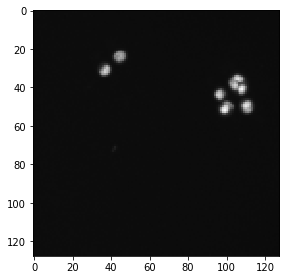

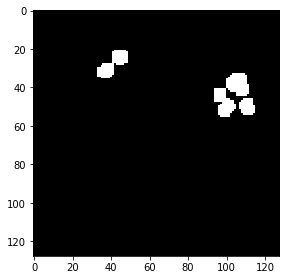

In [5]:
#Test Display
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

Developing the Model

In [9]:
#define the input layer
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
#convert each pixel integer into a floating point
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#contraction path (start with feature selection of 16 with 3,3 kernel)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
#Outputs
outputs = tf.keras.layers.Conv2D(1, (1,1), activation= 'sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 128, 128, 16) 0           conv2d_26[0][0]                  
______________________________________________________________________________________________

Model Fitting

In [10]:
#Model Checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

#Model Callbacks
callbacks = [
   tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
   tf.keras.callbacks.TensorBoard(log_dir='logs')
]


results = model.fit(X_train,Y_train, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)

Epoch 1/100
38/38 [==============================] - 27s 181ms/step - loss: 0.5612 - accuracy: 0.7541 - val_loss: 0.3266 - val_accuracy: 0.8186
Epoch 2/100
38/38 [==============================] - 4s 101ms/step - loss: 0.3108 - accuracy: 0.8414 - val_loss: 0.2215 - val_accuracy: 0.9156
Epoch 3/100
38/38 [==============================] - 4s 100ms/step - loss: 0.1856 - accuracy: 0.9306 - val_loss: 0.1458 - val_accuracy: 0.9441
Epoch 4/100
38/38 [==============================] - 4s 100ms/step - loss: 0.1396 - accuracy: 0.9458 - val_loss: 0.1471 - val_accuracy: 0.9479
Epoch 5/100
38/38 [==============================] - 4s 100ms/step - loss: 0.1273 - accuracy: 0.9512 - val_loss: 0.1146 - val_accuracy: 0.9562
Epoch 6/100
38/38 [==============================] - 4s 104ms/step - loss: 0.1243 - accuracy: 0.9529 - val_loss: 0.1425 - val_accuracy: 0.9510
Epoch 7/100
38/38 [==============================] - 4s 105ms/step - loss: 0.1171 - accuracy: 0.9556 - val_loss: 0.1116 - val_accuracy: 0.959

Showing Results

3/3 [==============================] - 0s 37ms/step


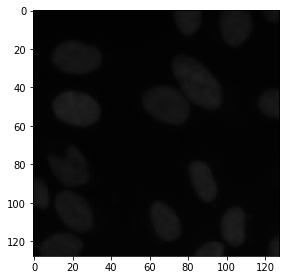

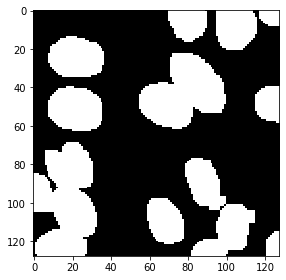

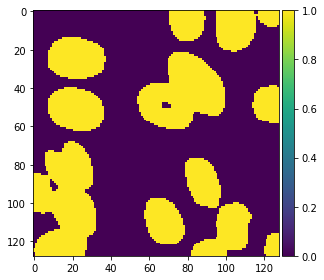

IndexError: index 303 is out of bounds for axis 0 with size 67

In [13]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)


#applying a threshold as every pixel has a probability value from 0-1
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Displaying Stats on TensorBoard

In [21]:
%tensorboard --logdir=logs/ --host localhost --port 8088